In [1]:
import duckdb
import pandas as pd
import json
import yaml
import openai
from tqdm import tqdm
import os
from pathlib import Path
import re
import chart_studio
import chart_studio.plotly as py

In [2]:
with open("config.yaml", "r") as stream:
    try:
        PARAM = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

openai.api_key  = PARAM['openai_api']
client = openai.OpenAI(api_key = PARAM['openai_api'])

def get_embedding(text, model=PARAM['vector_embedding_model']):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

username=PARAM['plotly_username']
api_key=PARAM['plotly_api_key']
chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

In [3]:
#con = duckdb.connect("drug.db")
con = duckdb.connect()


con.sql("INSTALL duckpgq FROM community;")
con.sql("INSTALL fts;")
con.sql("INSTALL vss;")

con.load_extension("duckpgq")
con.load_extension("fts")
con.load_extension("vss")

In [4]:
con.sql("""CREATE TABLE Trials (
            PostingID     INTEGER NOT NULL PRIMARY KEY,
            Sponsor    VARCHAR,
            StudyTitle     VARCHAR,
            Disorder   VARCHAR,
            Phase   VARCHAR,
            LinkToSponsorStudyRegistry   VARCHAR,
            LinkToClinicalTrials   VARCHAR,
            drug_cui  VARCHAR[],
            drug_names   VARCHAR[],
            )""")

con.sql("""CREATE TABLE Drug (
            drug_cui  VARCHAR NOT NULL PRIMARY KEY,
            name  VARCHAR
            )""")

con.sql("""CREATE TABLE Disorder (
            disorder_cui  VARCHAR NOT NULL PRIMARY KEY,
            name  VARCHAR,
            definition  VARCHAR,
            definitionEmbedding FLOAT[1536]
            )""")

con.sql("""CREATE TABLE MOA (
            moa_id  VARCHAR NOT NULL PRIMARY KEY,
            name  VARCHAR
            )""")

con.sql("""CREATE TABLE DrugDisorder (
            drug_cui  VARCHAR NOT NULL REFERENCES Drug(drug_cui),
            disorder_cui  VARCHAR NOT NULL REFERENCES Disorder(disorder_cui)
            )""")

con.sql("""CREATE TABLE DrugMOA (
            drug_cui  VARCHAR NOT NULL REFERENCES Drug(drug_cui),
            moa_id  VARCHAR NOT NULL REFERENCES MOA(moa_id)
            )""")

con.sql("""CREATE TABLE IF NOT EXISTS Prescription (
            name     VARCHAR NOT NULL,
            id    VARCHAR NOT NULL PRIMARY KEY,
            therapeutic_classes     VARCHAR[],
            brand_name_synonyms   VARCHAR[],
            generic_drug_synonyms   VARCHAR[],
            initial_FDA_approval_date   VARCHAR,
            
            "Top drug rank (2022)" INTEGER,
            "Estimated number of prescriptions in the United States (2022)" BIGINT,
            "Estimated number of patients in the United States (2022)" BIGINT,
            "Average total drug cost (USD)_Per prescription" DECIMAL(10,2),
            "Average total drug cost (USD)_Per day of therapy" DECIMAL(10,2),
            "Average out-of-pocket cost (USD)_Per prescription" DECIMAL(10,2),
            "Average out-of-pocket cost (USD)_Per day of therapy" DECIMAL(10,2),
            
            prescriptions_over_time STRUCT(
                year INTEGER,
                total_prescriptions BIGINT,
                total_patients BIGINT
            )[],
        prescription_cost_over_time STRUCT(
            year INTEGER,
            total DECIMAL(10,2), 
            out_of_pocket DECIMAL(10,2)
        )[],
        cost_per_day_over_time STRUCT(
            year INTEGER,
            total DECIMAL(10,2),
            out_of_pocket DECIMAL(10,2)
        )[],
        rank_over_time STRUCT(
            year INTEGER,
            rank INTEGER,
            change INTEGER
        )[],
        dosage_distribution STRUCT(
            dosage_form VARCHAR,
            strength VARCHAR,
            percentage DECIMAL(5,2)
        )[]);
        """)

con.sql(
    """
    CREATE TABLE PrescriptionRelatedDrugs (
            from_id VARCHAR NOT NULL,
            to_id VARCHAR NOT NULL
        );
        """
)


con.sql(
    """
    CREATE TABLE PrescriptionSubstance (
            from_id VARCHAR NOT NULL,
            to_cui VARCHAR NOT NULL
        );
        """
)

con.sql(
    """
    CREATE TABLE DrugDrugInteraction (
            from_cui VARCHAR NOT NULL,
            to_cui VARCHAR NOT NULL,
            level VARCHAR
        );
        """
)

con.sql("""SET hnsw_enable_experimental_persistence = true""")

con.sql("""CREATE INDEX my_hnsw_cosine_index ON Disorder USING HNSW (definitionEmbedding);""")


con.sql("""
CREATE PROPERTY GRAPH drug_graph
  VERTEX TABLES (
    Drug, Disorder, MOA, Prescription
  )
EDGE TABLES (
  DrugDisorder 	SOURCE KEY (drug_cui) REFERENCES Drug (drug_cui)
                DESTINATION KEY (disorder_cui) REFERENCES Disorder (disorder_cui)
  LABEL MAY_TREAT,
  DrugMOA SOURCE KEY (drug_cui) REFERENCES Drug (drug_cui)
          DESTINATION KEY (moa_id) REFERENCES MOA (moa_id)
  LABEL HAS_MOA,
  PrescriptionRelatedDrugs SOURCE KEY (from_id) REFERENCES Prescription (id)
                          DESTINATION KEY (to_id) REFERENCES Prescription (id)
  LABEL RELATED,
  PrescriptionSubstance SOURCE KEY (from_id) REFERENCES Prescription (id)
                      DESTINATION KEY (to_cui) REFERENCES Drug (drug_cui)
  LABEL CONTAINS_SUBSTANCE,
  DrugDrugInteraction SOURCE KEY (from_cui) REFERENCES Drug (drug_cui)
                      DESTINATION KEY (to_cui) REFERENCES Drug (drug_cui)
  LABEL INTERACTS_WITH
);
          """)

def get_embedding(text: str) -> list[float]:
   model="text-embedding-3-small"
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

con.create_function('embeddings', get_embedding)


In [5]:
df = pd.read_csv("drugs/trials_umls.tsv", sep='\t', lineterminator='\n')

con.sql("""BEGIN TRANSACTION;""")


for index, row in df.iterrows():
  con.execute("""
                INSERT INTO Trials (
                    PostingID,
                    Sponsor,
                    StudyTitle,
                    Disorder,
                    Phase,
                    LinkToSponsorStudyRegistry,
                    LinkToClinicalTrials,
                    drug_cui,
                    drug_names
                ) 
                SELECT 
                    $1,
                    $2,
                    $3,
                    $4,
                    $5,
                    $6,
                    $7,
                    $8::VARCHAR[],
                    $9::VARCHAR[]
            """, [
                row["Posting ID"],
                row["Sponsor"],
                row["Study Title"],
                row["Medical Condition"],
                row["Phase"],
                row["Link to Sponsor Study Registry"],
                row["Link to study details on ClinicalTrials.gov (if available)"],
                row["CUI_umls"].split(";"),
                row["preferred_umls_name"].split(";")
            ])

con.sql("""PRAGMA create_fts_index('Trials', 'PostingID', 'StudyTitle', overwrite=1);""")

con.sql("""COMMIT;""")



In [6]:
con.sql("""SELECT StudyTitle FROM Trials LIMIT 5;""")

┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                                                                                                      StudyTitle                                                                                                                      │
│                                                                                                                       varchar                                                                                                                        │
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ U0

In [7]:
db = "Trials"

query = f"""SELECT PostingID as trial_id, StudyTitle, score
FROM (
    SELECT *, fts_main_{db}.match_bm25(
        PostingID,
        'double blind & Valaciclovir',
        fields := 'StudyTitle'
    ) AS score
    FROM {db}
)
WHERE score IS NOT NULL
ORDER BY score DESC LIMIT 5;
"""

con.sql(query)

┌──────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────┐
│ trial_id │                                                                                                      StudyTitle                                                                                                       │       score        │
│  int32   │                                                                                                        varchar                                                                                                        │       double       │
├──────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────┤


In [8]:
con.sql("""BEGIN TRANSACTION;""")

for line in open("drugs/drugs_8.json", "r"):
  value = json.loads(line)

  con.execute("""
                INSERT INTO Drug (
                    drug_cui,
                    name
                ) 
                SELECT 
                    $1,
                    $2
            """, [
                value["cui"],
                value["name"]
            ])

  #query = f"""INSERT INTO Drug VALUES ('{value["cui"]}', '{value["name"].replace("'", "''")}');"""
  #print(query)
  #con.sql(query)

con.sql("""COMMIT;""")

In [9]:
con.sql("""
SELECT * FROM Drug WHERE drug_cui = 'C0046056'
""")

┌──────────┬────────────────────────┐
│ drug_cui │          name          │
│ varchar  │        varchar         │
├──────────┼────────────────────────┤
│ C0046056 │ fluorodeoxyglucose F18 │
└──────────┴────────────────────────┘

In [10]:
con.sql("""BEGIN TRANSACTION;""")

for line in open("drugs/disease_8_embedding.json", "r"):
  value = json.loads(line)

  con.execute("""
                INSERT INTO Disorder (
                    disorder_cui,
                    name,
                    definition,
                    definitionEmbedding
                ) 
                SELECT 
                    $1,
                    $2,
                    $3,
                    $4::FLOAT[1536]
            """, [
                value["cui"],
                value["name"],
                value["definition"],
                value["definitionEmbedding"]
            ])

  #query = f"""INSERT INTO Disorder VALUES ('{value["cui"]}', '{value["name"].replace("'", "''")}', '{value["definition"].replace("'", "''")}', {value["definitionEmbedding"]});"""
  #print(query)
  #con.sql(query)

con.sql("""COMMIT;""")

In [11]:
con.sql("""BEGIN TRANSACTION;""")

df = pd.read_csv("drugs/moa_8.tsv", sep='\t', lineterminator='\n')

for index, row in df.iterrows():

    con.execute("""
                INSERT INTO MOA (
                    moa_id,
                    name
                ) 
                SELECT 
                    $1,
                    $2
            """, [
                row["id"],
                row["name"]
            ])

  #query = f"""INSERT INTO MOA VALUES ('{row["id"]}', '{row["name"].replace("'", "''")}');"""
  #print(query)
  #con.sql(query)


con.sql("""COMMIT;""")

In [12]:
con.sql("""BEGIN TRANSACTION;""")
df = pd.read_csv("drugs/cui_indication_8.tsv", sep='\t', lineterminator='\n')

for index, row in df.iterrows():
    con.execute("""
              INSERT INTO DrugDisorder (
                  drug_cui,
                  disorder_cui
              ) 
              SELECT 
                  $1,
                  $2
          """, [
              row["from"],
              row["to"]
          ])
  #query = f"""INSERT INTO DrugDisorder VALUES ('{row["from"]}', '{row["to"]}');"""
  #con.sql(query)



con.sql("""COMMIT;""")

In [13]:
con.sql("""BEGIN TRANSACTION;""")
df = pd.read_csv("drugs/cui_moa_8.tsv", sep='\t', lineterminator='\n')

for index, row in df.iterrows():
  con.execute("""
              INSERT INTO DrugMOA (
                  drug_cui,
                  moa_id
              ) 
              SELECT 
                  $1,
                  $2
          """, [
              row["from"],
              row["to"]
          ])
  

  #query = f"""INSERT INTO DrugMOA VALUES ('{row["from"]}', '{row["to"]}');"""
  #con.sql(query)


con.sql("""COMMIT;""")

In [14]:
con.sql("""BEGIN TRANSACTION;""")
df = pd.read_csv("drugs/ddinter_cui_interaction.tsv", sep='\t', lineterminator='\n')

for index, row in df.iterrows():
    con.execute("""
              INSERT INTO DrugDrugInteraction (
                  from_cui,
                  to_cui,
                  level
              ) 
              SELECT 
                  $1,
                  $2,
                  $3
          """, [
              row["from_cui"],
              row["to_cui"],
              row["level"]
          ])


  #query = f"""INSERT INTO DrugDrugInteraction VALUES ('{row["from_cui"]}', '{row["to_cui"]}', '{row["level"]}');"""
  #con.sql(query)


con.sql("""COMMIT;""")

In [15]:
con.sql("""
FROM GRAPH_TABLE (drug_graph
  MATCH
  (i:Drug)-[m:MAY_TREAT]->(c:Disorder WHERE c.name = 'Alzheimer''s Disease')
  COLUMNS (i.name AS drug_name)
)
LIMIT 5;
""")

┌──────────────────────────┐
│        drug_name         │
│         varchar          │
├──────────────────────────┤
│ tocopherol acetate       │
│ valproic acid            │
│ rivastigmine tartrate    │
│ aducanumab               │
│ galantamine hydrobromide │
└──────────────────────────┘

In [16]:
con.sql("""FROM GRAPH_TABLE (drug_graph
        MATCH
        (d:Drug WHERE d.name = 'medrysone')-[h:HAS_MOA]->(m:MOA)
        COLUMNS (m.name AS moa_name)
      )
      LIMIT 5;""")

┌──────────────────────────────────────────┐
│                 moa_name                 │
│                 varchar                  │
├──────────────────────────────────────────┤
│ Lipoxygenase Inhibitors                  │
│ Corticosteroid Hormone Receptor Agonists │
│ Glucocorticoid Receptor Agonists         │
└──────────────────────────────────────────┘

In [17]:
con.sql("""
SELECT Trials.PostingID as trial_id, Trials.drug_cui, drug_for_disease.drug_cui
FROM Trials,
    GRAPH_TABLE(
            drug_graph
                MATCH
                (i:Drug)-[m:MAY_TREAT]->(c:Disorder WHERE c.name = 'Alzheimer''s Disease')
                COLUMNS (i.drug_cui AS drug_cui)
    )  drug_for_disease
WHERE list_contains(Trials.drug_cui, drug_for_disease.drug_cui)
""")

┌──────────┬────────────┬────────────┐
│ trial_id │  drug_cui  │ drug_cui_1 │
│  int32   │ varchar[]  │  varchar   │
├──────────┼────────────┼────────────┤
│     4086 │ [C0649350] │ C0649350   │
│     4179 │ [C0649350] │ C0649350   │
│     4180 │ [C0649350] │ C0649350   │
│     4556 │ [C0649350] │ C0649350   │
│     4688 │ [C0649350] │ C0649350   │
│     4689 │ [C0649350] │ C0649350   │
│     4749 │ [C0649350] │ C0649350   │
│    19970 │ [C0527316] │ C0527316   │
│    19971 │ [C0527316] │ C0527316   │
│    19972 │ [C0527316] │ C0527316   │
│    19973 │ [C0527316] │ C0527316   │
│    19974 │ [C0527316] │ C0527316   │
│    19975 │ [C0527316] │ C0527316   │
│    19976 │ [C0527316] │ C0527316   │
│    19977 │ [C0527316] │ C0527316   │
│    19978 │ [C0527316] │ C0527316   │
│    19979 │ [C0527316] │ C0527316   │
│    19980 │ [C0527316] │ C0527316   │
│    20782 │ [C0527316] │ C0527316   │
│    20783 │ [C0527316] │ C0527316   │
│    20784 │ [C0527316] │ C0527316   │
│    21103 │ [C0649350] │

In [18]:
con.sql("""
SELECT Trials.PostingID as trial_id, Trials.drug_cui, Drug.drug_cui
FROM Trials, Drug, Disorder, DrugDisorder
WHERE Disorder.name = 'Alzheimer''s Disease' 
  AND Disorder.disorder_cui = DrugDisorder.disorder_cui 
  AND Drug.drug_cui = DrugDisorder.drug_cui 
  AND list_contains(Trials.drug_cui, Drug.drug_cui)
""")

┌──────────┬────────────┬──────────┐
│ trial_id │  drug_cui  │ drug_cui │
│  int32   │ varchar[]  │ varchar  │
├──────────┼────────────┼──────────┤
│     4086 │ [C0649350] │ C0649350 │
│     4179 │ [C0649350] │ C0649350 │
│     4180 │ [C0649350] │ C0649350 │
│     4556 │ [C0649350] │ C0649350 │
│     4688 │ [C0649350] │ C0649350 │
│     4689 │ [C0649350] │ C0649350 │
│     4749 │ [C0649350] │ C0649350 │
│    21103 │ [C0649350] │ C0649350 │
│    19970 │ [C0527316] │ C0527316 │
│    19971 │ [C0527316] │ C0527316 │
│    19972 │ [C0527316] │ C0527316 │
│    19973 │ [C0527316] │ C0527316 │
│    19974 │ [C0527316] │ C0527316 │
│    19975 │ [C0527316] │ C0527316 │
│    19976 │ [C0527316] │ C0527316 │
│    19977 │ [C0527316] │ C0527316 │
│    19978 │ [C0527316] │ C0527316 │
│    19979 │ [C0527316] │ C0527316 │
│    19980 │ [C0527316] │ C0527316 │
│    20782 │ [C0527316] │ C0527316 │
│    20783 │ [C0527316] │ C0527316 │
│    20784 │ [C0527316] │ C0527316 │
├──────────┴────────────┴──────────┤
│

In [19]:
con.sql("""
SELECT Trials.PostingID as trial_id, Trials.drug_cui, Drug.drug_cui
FROM Trials, Drug
JOIN DrugDisorder dd ON Drug.drug_cui = dd.drug_cui
JOIN Disorder d ON dd.disorder_cui = d.disorder_cui
WHERE d.name = 'Alzheimer''s Disease' AND list_contains(Trials.drug_cui, Drug.drug_cui)
""")

┌──────────┬────────────┬──────────┐
│ trial_id │  drug_cui  │ drug_cui │
│  int32   │ varchar[]  │ varchar  │
├──────────┼────────────┼──────────┤
│     4086 │ [C0649350] │ C0649350 │
│     4179 │ [C0649350] │ C0649350 │
│     4180 │ [C0649350] │ C0649350 │
│     4556 │ [C0649350] │ C0649350 │
│     4688 │ [C0649350] │ C0649350 │
│     4689 │ [C0649350] │ C0649350 │
│     4749 │ [C0649350] │ C0649350 │
│    19970 │ [C0527316] │ C0527316 │
│    19971 │ [C0527316] │ C0527316 │
│    19972 │ [C0527316] │ C0527316 │
│    19973 │ [C0527316] │ C0527316 │
│    19974 │ [C0527316] │ C0527316 │
│    19975 │ [C0527316] │ C0527316 │
│    19976 │ [C0527316] │ C0527316 │
│    19977 │ [C0527316] │ C0527316 │
│    19978 │ [C0527316] │ C0527316 │
│    19979 │ [C0527316] │ C0527316 │
│    19980 │ [C0527316] │ C0527316 │
│    20782 │ [C0527316] │ C0527316 │
│    20783 │ [C0527316] │ C0527316 │
│    20784 │ [C0527316] │ C0527316 │
│    21103 │ [C0649350] │ C0649350 │
├──────────┴────────────┴──────────┤
│

In [20]:
question = "joint-related disease"

question_embedding = get_embedding(question)

con.sql(f"""
SELECT name, definition
FROM Disorder
ORDER BY array_distance(definitionEmbedding, {question_embedding}::FLOAT[1536])
LIMIT 3;
""")



┌──────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│         name         │                                                                                                                                                                                              definition                                                                                                                                                                                               │
│       varchar        │                                                                                                                                              

In [21]:
con.sql(f"""
SELECT Trials.PostingID AS trial_id, target_disease.name, drug_for_disorder.drug_name FROM 
  Trials, (
  SELECT disorder_cui, name
    FROM Disorder
    ORDER BY array_distance(definitionEmbedding, {question_embedding}::FLOAT[1536])
    LIMIT 3
  ) target_disease,
  GRAPH_TABLE(
    drug_graph
      MATCH (i:Drug)-[m:MAY_TREAT]->(c:Disorder)
      COLUMNS (i.drug_cui AS drug_cui, i.name AS drug_name,c.disorder_cui AS disorder_cui)
    )  drug_for_disorder
WHERE target_disease.disorder_cui = drug_for_disorder.disorder_cui AND list_contains(Trials.drug_cui, drug_for_disorder.drug_cui)
""")

┌──────────┬──────────────────────┬────────────────────┐
│ trial_id │         name         │     drug_name      │
│  int32   │       varchar        │      varchar       │
├──────────┼──────────────────────┼────────────────────┤
│     4829 │ Rheumatoid Arthritis │ certolizumab pegol │
│     4774 │ Rheumatoid Arthritis │ aspirin            │
│     4775 │ Rheumatoid Arthritis │ aspirin            │
│     3610 │ Rheumatoid Arthritis │ nabumetone         │
│      121 │ Rheumatoid Arthritis │ naproxen           │
│      122 │ Rheumatoid Arthritis │ naproxen           │
│      123 │ Rheumatoid Arthritis │ naproxen           │
│     3474 │ Rheumatoid Arthritis │ naproxen           │
│     3475 │ Rheumatoid Arthritis │ naproxen           │
│     3476 │ Rheumatoid Arthritis │ naproxen           │
│       ·  │          ·           │    ·               │
│       ·  │          ·           │    ·               │
│       ·  │          ·           │    ·               │
│     3489 │ Rheumatoid Arthrit

In [22]:
con.sql("""
                    FROM GRAPH_TABLE (drug_graph
                    MATCH
                    (mo:MOA)<-[h:HAS_MOA]-(i:Drug)-[m:MAY_TREAT]->(c:Disorder WHERE c.name = 'Alzheimer''s Disease')
                    COLUMNS (mo.name AS moa_name)
                    )
                    LIMIT 5;
""")

┌──────────────────────────────────┐
│             moa_name             │
│             varchar              │
├──────────────────────────────────┤
│ Free Radical Scavenging Activity │
│ GABA B Receptor Interactions     │
│ GABA A Receptor Interactions     │
│ Monoamine Oxidase Inhibitors     │
│ Monoamine Oxidase-B Inhibitors   │
└──────────────────────────────────┘

In [23]:
con.sql("""
                    FROM GRAPH_TABLE (drug_graph
                    MATCH
                    (mo:MOA WHERE mo.name = 'GABA B Receptor Interactions')<-[h:HAS_MOA]-(i:Drug)-[m:MAY_TREAT]->(c:Disorder)
                    COLUMNS (c.name AS disorder_name)
                    )
                    LIMIT 5;
""")

┌─────────────────────┐
│    disorder_name    │
│       varchar       │
├─────────────────────┤
│ Alzheimer's Disease │
│ Epilepsy            │
│ Bipolar Disorder    │
│ Absence Epilepsy    │
│ Mood Disorders      │
└─────────────────────┘

In [24]:
con.sql("""
    SELECT Trials.StudyTitle as StudyTitle, drug_for_disease.drug_cui
    FROM Trials,
    GRAPH_TABLE(
        drug_graph
        MATCH
        (i:Drug)-[m:MAY_TREAT]->(c:Disorder WHERE c.name = 'Alzheimer''s Disease')
        COLUMNS (i.drug_cui AS drug_cui)
    )  drug_for_disease
    WHERE list_contains(Trials.drug_cui, drug_for_disease.drug_cui)
    LIMIT 5;
""")

┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────┐
│                                                                                                                                      StudyTitle                                                                                                                                       │ drug_cui │
│                                                                                                                                        varchar                                                                                                                                        │ varchar  │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [25]:
con.sql("""
SELECT Sponsor, Phase, COUNT(PostingID) AS trial_count
                FROM Trials, Drug
                WHERE LOWER(Drug.name) = LOWER('Fluticasone pRopionate') AND list_contains(Trials.drug_cui, Drug.drug_cui)
                GROUP BY Sponsor, Phase
                ORDER BY Sponsor, Phase;
""")

┌──────────┬─────────┬─────────────┐
│ Sponsor  │  Phase  │ trial_count │
│ varchar  │ varchar │    int64    │
├──────────┼─────────┼─────────────┤
│ GSK      │ Phase 1 │          27 │
│ GSK      │ Phase 2 │           6 │
│ GSK      │ Phase 3 │          39 │
│ GSK      │ Phase 4 │          80 │
│ GSK      │ nan     │           3 │
│ Novartis │ Phase 2 │           1 │
└──────────┴─────────┴─────────────┘

In [26]:
con.sql("""
SELECT Disorder.name 
                        FROM DrugDisorder, Drug, Disorder
                        WHERE DrugDisorder.drug_cui = Drug.drug_cui
                        AND DrugDisorder.disorder_cui = Disorder.disorder_cui
                        AND LOWER(Drug.name) = LOWER('fluocinolone acetonide');
""")

┌────────────────────┐
│        name        │
│      varchar       │
├────────────────────┤
│ Hand Dermatoses    │
│ Foot Dermatoses    │
│ Dermatitis, Atopic │
│ Scalp Dermatoses   │
│ Psoriasis          │
│ Inflammation       │
│ Facial Dermatoses  │
│ Pruritus           │
│ Leg Dermatoses     │
└────────────────────┘

In [27]:
root = "/Users/dgg32/Documents/drug_atc"

json_dir = f"{root}/test/clincalc_json/"

re_rank = re.compile(r'#(\d+) \(.+?\)')

con.sql("BEGIN TRANSACTION;")

try:
    pathlist = Path(json_dir).rglob('*.json')
    for path in tqdm(pathlist):
        with open(path, 'r') as file:
            data = json.load(file)
            
            # Clean up data
            # Handle ≤ symbol in summary
            for f in data["summary"]:
                if isinstance(data["summary"][f], str) and "\u2264" in data["summary"][f]:
                    data["summary"][f] = float(data["summary"][f].replace("\u2264", ""))
                if isinstance(data["summary"][f], str) and re_rank.match(data["summary"][f]):
                    data["summary"][f] = int(re_rank.match(data["summary"][f]).group(1))
            
            # Handle optional arrays
            data["dosage_distribution"] = data.get("dosage_distribution", [])
            data["brand_name_synonyms"] = data.get("brand_name_synonyms", [])
            data["generic_drug_synonyms"] = data.get("generic_drug_synonyms", [])
            
            # Use parameterized query instead of string formatting
            con.execute("""
                INSERT INTO Prescription (
                    name, 
                    id, 
                    therapeutic_classes,
                    brand_name_synonyms,
                    generic_drug_synonyms,
                    initial_FDA_approval_date,
                    "Top drug rank (2022)",
                    "Estimated number of prescriptions in the United States (2022)",
                    "Estimated number of patients in the United States (2022)",
                    "Average total drug cost (USD)_Per prescription",
                    "Average total drug cost (USD)_Per day of therapy",
                    "Average out-of-pocket cost (USD)_Per prescription",
                    "Average out-of-pocket cost (USD)_Per day of therapy",
                    prescriptions_over_time,
                    prescription_cost_over_time,
                    cost_per_day_over_time,
                    rank_over_time,
                    dosage_distribution
                ) 
                SELECT 
                    $1,
                    $2,
                    $3::VARCHAR[],
                    $4::VARCHAR[],
                    $5::VARCHAR[],
                    $6,
                    $7,
                    $8,
                    $9,
                    $10,
                    $11,
                    $12,
                    $13,
                    $14,
                    $15,
                    $16,
                    $17,
                    $18
            """, [
                data["name"],
                data["id"],
                data["therapeutic_classes"],
                data["brand_name_synonyms"],
                data["generic_drug_synonyms"],
                data["initial_FDA_approval_date"],
                data["summary"]["Top drug rank"],
                data["summary"]["Estimated number of prescriptions in the United States (2022)"],
                data["summary"]["Estimated number of patients in the United States (2022)"],
                data["summary"]["Average total drug cost (USD)_Per prescription"],
                data["summary"]["Average total drug cost (USD)_Per day of therapy"],
                data["summary"]["Average out-of-pocket cost (USD)_Per prescription"],
                data["summary"]["Average out-of-pocket cost (USD)_Per day of therapy"],
                data["prescriptions_over_time"],
                data["prescription_cost_over_time"],
                data["cost_per_day_over_time"],
                data["rank_over_time"],
                data["dosage_distribution"]
            ])

            con.execute("""
                INSERT INTO PrescriptionRelatedDrugs (from_id, to_id)
                SELECT $1, unnest($2::VARCHAR[])
            """, [
                data["id"],
                data.get("related_drugs", [])
            ])
            
    # Commit transaction if everything succeeded
    con.sql("COMMIT;")
    print("Import completed successfully!")
    
except Exception as e:
    # Rollback transaction if there was an error
    con.sql("ROLLBACK;")
    print(f"Error occurred: {e}")
    raise


344it [00:00, 1117.56it/s]

Import completed successfully!


In [28]:
con.sql("BEGIN TRANSACTION;")

#prescription_substance = {}

for index, row in pd.read_csv(f"{root}/test/top_344_drugs_manual_annotated.tsv", sep="\t").iterrows():
    con.execute("""
                INSERT INTO PrescriptionSubstance (from_id, to_cui)
                SELECT $1, unnest($2::VARCHAR[])
            """, [
                row["id"],
                [x.strip() for x in row["CUI"].split(";")]
            ])
    
    # for cui, name in zip(row["CUI"].split(";"), row["Preferred_Name"].split(";")):
    #     prescription_substance[cui] = name
    #con.execute("INSERT INTO PrescriptionSubstance (from_id, to_cui) VALUES (?, ?)", [row["Drug_Name"], row["CUI"]])

con.sql("COMMIT;")

In [29]:
con.execute("SELECT * FROM PrescriptionSubstance").fetch_df()

,from_id,to_cui
0,Drugs/Dapagliflozin,C2353951
1,Drugs/UmeclidiniumVilanterol,C3661274
2,Drugs/UmeclidiniumVilanterol,C2935023
3,Drugs/DextromethorphanGuaifenesinPhenylephrine,C0011816
4,Drugs/DextromethorphanGuaifenesinPhenylephrine,C0018305
...,...,...
436,Drugs/Metformin,C0025598
437,Drugs/AcetaminophenOxycodone,C0000970
438,Drugs/AcetaminophenOxycodone,C0030049
439,Drugs/Sildenafil,C0529793


In [30]:
con.sql("""
    SELECT COUNT(*) FROM
    Prescription
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│          344 │
└──────────────┘

In [31]:
con.sql("""
    SELECT list_filter(Pre.prescriptions_over_time, x -> x.year = 2022)[1].total_prescriptions FROM
    GRAPH_TABLE(
        drug_graph
        MATCH
        (p:Prescription)-[m:CONTAINS_SUBSTANCE]->(d:Drug WHERE d.name = 'prednisone')
        COLUMNS (p.prescriptions_over_time AS prescriptions_over_time)
    ) Pre
""")

┌─────────────────────────────────────────────────────────────────────────────────────────────┐
│ (list_filter(Pre.prescriptions_over_time, (x -> (x."year" = 2022)))[1]).total_prescriptions │
│                                            int64                                            │
├─────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                    18201857 │
└─────────────────────────────────────────────────────────────────────────────────────────────┘

In [32]:
con.sql("""
    SELECT t.unnest.total_prescriptions
    FROM
    GRAPH_TABLE(
        drug_graph
        MATCH
        (p:Prescription)-[m:CONTAINS_SUBSTANCE]->(d:Drug WHERE d.name = 'prednisone')
        COLUMNS (p.prescriptions_over_time AS prescriptions_over_time)
    ) Pre,
    unnest(Pre.prescriptions_over_time) AS t
    WHERE t.unnest.year = 2022
""")

┌─────────────────────┐
│ total_prescriptions │
│        int64        │
├─────────────────────┤
│            18201857 │
└─────────────────────┘

In [33]:
con.sql("""
    SELECT *
    FROM
    GRAPH_TABLE(
        drug_graph
        MATCH
        (p1:Prescription)<-[r:RELATED]-(p:Prescription)-[m:CONTAINS_SUBSTANCE]->(d:Drug WHERE d.name = 'prednisone')
        COLUMNS (p1.name AS name1, p.name AS name2)
    ) Pre
""")

┌───────────────────────────────────────┬────────────┐
│                 name1                 │   name2    │
│                varchar                │  varchar   │
├───────────────────────────────────────┼────────────┤
│ Fluocinolone; Hydroquinone; Tretinoin │ Prednisone │
│ Budesonide                            │ Prednisone │
│ Betamethasone; Clotrimazole           │ Prednisone │
│ Hydrocortisone                        │ Prednisone │
│ Betamethasone                         │ Prednisone │
│ Fluticasone; Salmeterol               │ Prednisone │
│ Fluticasone                           │ Prednisone │
│ Mometasone                            │ Prednisone │
│ Ciprofloxacin; Dexamethasone          │ Prednisone │
│ Triamcinolone                         │ Prednisone │
│ Fluticasone; Vilanterol               │ Prednisone │
│ Prednisolone                          │ Prednisone │
│ Methylprednisolone                    │ Prednisone │
│ Dexamethasone                         │ Prednisone │
│ Budesoni

In [34]:
con.sql("""
      
        SELECT name, t.unnest.out_of_pocket
        FROM Prescription,
        UNNEST (prescription_cost_over_time) AS t
        WHERE t.unnest.year = 2022
        ORDER BY t.unnest.out_of_pocket DESC
        LIMIT 5
      
""")

┌───────────────────────┬───────────────┐
│         name          │ out_of_pocket │
│        varchar        │ decimal(10,2) │
├───────────────────────┼───────────────┤
│ Adalimumab            │        255.12 │
│ Sacubitril; Valsartan │         92.19 │
│ Insulin Detemir       │         89.53 │
│ Apixaban              │         89.17 │
│ Liraglutide           │         79.97 │
└───────────────────────┴───────────────┘

In [35]:
con.sql("""
      WITH top_5_prescriptions AS (
        SELECT name, t.unnest.out_of_pocket
        FROM Prescription,
        UNNEST (prescription_cost_over_time) AS t
        WHERE t.unnest.year = 2022
        ORDER BY t.unnest.out_of_pocket DESC
        LIMIT 5)
      SELECT top_5_prescriptions.name, top_5_prescriptions.out_of_pocket, drug_name FROM top_5_prescriptions,
        GRAPH_TABLE(
            drug_graph
            MATCH
            (p:Prescription)-[m:CONTAINS_SUBSTANCE]->(d:Drug)
            COLUMNS (p.name AS prescription_name, d.name AS drug_name)
        ) Pre
      WHERE top_5_prescriptions.name = Pre.prescription_name
      ORDER BY top_5_prescriptions.out_of_pocket DESC
""")

┌───────────────────────┬───────────────┬─────────────────┐
│         name          │ out_of_pocket │    drug_name    │
│        varchar        │ decimal(10,2) │     varchar     │
├───────────────────────┼───────────────┼─────────────────┤
│ Adalimumab            │        255.12 │ adalimumab      │
│ Sacubitril; Valsartan │         92.19 │ sacubitril      │
│ Sacubitril; Valsartan │         92.19 │ valsartan       │
│ Insulin Detemir       │         89.53 │ insulin detemir │
│ Apixaban              │         89.17 │ apixaban        │
│ Liraglutide           │         79.97 │ liraglutide     │
└───────────────────────┴───────────────┴─────────────────┘

In [36]:
con.sql("""
    SELECT *
    FROM
    GRAPH_TABLE(
        drug_graph
        MATCH
        (d1:Drug)-[m:INTERACTS_WITH]->(d2:Drug WHERE d2.name = 'rucaparib')
        COLUMNS (d1.name AS names, m.level AS level)
    )
        WHERE level = 'Major'
      LIMIT 5
""")

┌───────────────┬─────────┐
│     names     │  level  │
│    varchar    │ varchar │
├───────────────┼─────────┤
│ infliximab    │ Major   │
│ tofacitinib   │ Major   │
│ etanercept    │ Major   │
│ teriflunomide │ Major   │
│ vandetanib    │ Major   │
└───────────────┴─────────┘

1. Prescription Volume and Drug Interactions: "Which commonly prescribed medications in 2022 have the highest number of severe drug-drug interactions, and what alternative treatments with similar mechanisms of action (MOA) might present fewer interaction risks?”: A scatter chart with interaction count vs prescription, and then search for alternative?

In [37]:
query = """
SELECT 
  "rank", 
  name, 
  ingredient_name, 
  COUNT(d2_name) AS major_dd_count
FROM
GRAPH_TABLE(
  drug_graph
  MATCH
  (p:Prescription)-[m:CONTAINS_SUBSTANCE]->(d:Drug)-[i:INTERACTS_WITH WHERE i.level = 'Major']->(d2:Drug)
  COLUMNS (p."Top drug rank (2022)" AS rank, p.name AS name, d.name AS ingredient_name, d2.name AS d2_name)
) 
GROUP BY "rank", name, ingredient_name
ORDER BY major_dd_count DESC;
"""

popular_prescription = con.execute(query).fetch_df()
popular_prescription_most_dd_only = popular_prescription.sort_values('major_dd_count').drop_duplicates(["rank", "name"], keep='last')
popular_prescription_most_dd_only.sort_values('major_dd_count', ascending=False)

,rank,name,ingredient_name,major_dd_count
0,175,Ketoconazole,ketoconazole,184
1,349,Homatropine; Hydrocodone,hydrocodone,158
2,23,Acetaminophen; Hydrocodone,hydrocodone,158
3,354,Hydrocodone; Chlorpheniramine,hydrocodone,158
4,271,Erythromycin,erythromycin,155
...,...,...,...,...
300,171,Olanzapine,olanzapine,1
299,190,Rizatriptan,rizatriptan,1
298,196,Nitroglycerin,nitroglycerin,1
297,81,Lorazepam,lorazepam,1


In [38]:
popular_prescription_most_dd_only.sort_values('major_dd_count', ascending=False).head(20).to_csv("popular_prescription_most_dd_only.csv", index=False)

In [39]:
query = """
SELECT 
name,
ingredient_name,
COUNT(dd_drug_name) AS major_dd_count
FROM
GRAPH_TABLE(
  drug_graph
  MATCH
  (p:Prescription WHERE p.name = 'Erythromycin')<-[m:RELATED]-(d:Prescription)-[c:CONTAINS_SUBSTANCE]->(ingredient:Drug)-[i:INTERACTS_WITH WHERE i.level = 'Major']->(dd_drug:Drug)
  COLUMNS (d.name AS name, ingredient.name AS ingredient_name, dd_drug.name AS dd_drug_name)
) 
WHERE ingredient_name != 'erythromycin'
GROUP BY name, ingredient_name
"""

popular_prescription = con.execute(query).fetch_df()
popular_prescription.sort_values('major_dd_count')

,name,ingredient_name,major_dd_count
0,Azithromycin,azithromycin,25


In [40]:
query = """
SELECT 
ingredient_name,
MOA_name,
COUNT(dd_drug_name) AS major_dd_count
FROM
GRAPH_TABLE(
  drug_graph
  MATCH
  (p:Drug WHERE p.name = 'erythromycin')-[h:HAS_MOA]->(m:MOA)<-[h2:HAS_MOA]-(d:Drug)-[i:INTERACTS_WITH WHERE i.level = 'Major']->(dd_drug:Drug)
  COLUMNS (d.name AS ingredient_name, m.name as MOA_name, dd_drug.name AS dd_drug_name)
)
WHERE ingredient_name != 'erythromycin'
GROUP BY ingredient_name, MOA_name
"""

popular_prescription = con.execute(query).fetch_df()
popular_prescription.sort_values('major_dd_count').head(5).to_csv("popular_prescription_most_dd_only.csv", index=False)

In [41]:
query = """
SELECT 
ingredient_name,
disorder_name,
COUNT(dd_drug_name) AS major_dd_count
FROM
GRAPH_TABLE(
  drug_graph
  MATCH
  (p:Drug WHERE p.name = 'erythromycin')-[h:MAY_TREAT]->(di:Disorder)<-[h2:MAY_TREAT]-(d:Drug)-[i:INTERACTS_WITH WHERE i.level = 'Major']->(dd_drug:Drug)
  COLUMNS (d.name AS ingredient_name, di.name as disorder_name, dd_drug.name AS dd_drug_name)
)
WHERE ingredient_name != 'erythromycin'
GROUP BY ingredient_name, disorder_name
"""

popular_prescription = con.execute(query).fetch_df()
popular_prescription.sort_values('major_dd_count')

,ingredient_name,disorder_name,major_dd_count
197,sulfadiazine,Chancroid,1
30,piperacillin,Streptococcal Infections,1
156,ampicillin,Gonorrhea,1
163,sulfisoxazole,Chlamydia Infections,1
44,delafloxacin,Staphylococcal Infections,1
...,...,...,...
50,clarithromycin,Bacterial Infections,150
174,clarithromycin,Streptococcal Infections,150
32,clarithromycin,Staphylococcal Infections,150
27,clarithromycin,Protozoan Infections,150


In [42]:
query = """
SELECT 
ingredient_name,
disorder_name,
MOA_name,
COUNT(dd_drug_name) AS major_dd_count
FROM
GRAPH_TABLE(
  drug_graph
  MATCH
  (p:Drug WHERE p.name = 'erythromycin')-[h:MAY_TREAT]->(di:Disorder)<-[h2:MAY_TREAT]-(d:Drug)-[h3:HAS_MOA]->(m:MOA)<-[h4:HAS_MOA]-(p:Drug),
  (d:Drug)-[i:INTERACTS_WITH WHERE i.level = 'Major']->(dd_drug:Drug)
  COLUMNS (d.name AS ingredient_name, di.name as disorder_name, dd_drug.name AS dd_drug_name, m.name AS MOA_name)
)
WHERE ingredient_name != 'erythromycin'
GROUP BY ingredient_name, disorder_name, MOA_name
"""

popular_prescription = con.execute(query).fetch_df()
popular_prescription.sort_values('major_dd_count')

,ingredient_name,disorder_name,MOA_name,major_dd_count
81,tedizolid,Staphylococcal Infections,Protein Synthesis Inhibitors,1
26,clindamycin,Acne Vulgaris,Protein Synthesis Inhibitors,1
54,clindamycin,Streptococcal Infections,Protein Synthesis Inhibitors,1
7,clindamycin,Staphylococcal Infections,Protein Synthesis Inhibitors,1
47,clindamycin,Bacterial Infections,Protein Synthesis Inhibitors,1
...,...,...,...,...
35,clarithromycin,Protozoan Infections,Protein Synthesis Inhibitors,150
14,clarithromycin,Streptococcal Infections,Protein Synthesis Inhibitors,150
11,clarithromycin,Bacterial Infections,Protein Synthesis Inhibitors,150
79,clarithromycin,Staphylococcal Infections,Protein Synthesis Inhibitors,150


2. Are there more clincal trials for popular drugs?

In [43]:
query = """
SELECT 
  "rank", 
  "cost",
  name, 
  drug_name,
  COUNT(PostingID) AS trial_count
FROM
GRAPH_TABLE(
  drug_graph
  MATCH
  (p:Prescription)-[m:CONTAINS_SUBSTANCE]->(d:Drug)
  COLUMNS (p."Top drug rank (2022)" AS rank, 
          p."Average total drug cost (USD)_Per prescription" AS cost, 
          p.name AS name, 
          d.name AS drug_name, 
          d.drug_cui AS drug_cui)
) Pre,
Trials
WHERE list_contains(Trials.drug_cui, Pre.drug_cui)
GROUP BY "rank", "cost", name, drug_name
"""



popular_prescription = con.execute(query).fetch_df()
popular_prescription

,rank,cost,name,drug_name,trial_count
0,221,11.60,Sodium Fluoride,sodium fluoride,1
1,34,16.45,Carvedilol,carvedilol,17
2,36,4.80,Aspirin,aspirin,2
3,2,70.33,Metformin,metformin,15
4,141,18.60,Enalapril,enalapril,1
...,...,...,...,...,...
61,92,19.10,Paroxetine,paroxetine,104
62,12,8.36,Hydrochlorothiazide,hydrochlorothiazide,1
63,165,1225.78,Sacubitril; Valsartan,valsartan,7
64,145,532.17,Fluticasone; Vilanterol,fluticasone,1


In [44]:
query = """
WITH drug_trials AS (
  SELECT 
    "rank", 
    "cost",
    name, 
    drug_name,
    COUNT(PostingID) AS trial_count
  FROM
  GRAPH_TABLE(
    drug_graph
    MATCH
    (p:Prescription)-[m:CONTAINS_SUBSTANCE]->(d:Drug)
    COLUMNS (p."Top drug rank (2022)" AS rank, 
            p."Average total drug cost (USD)_Per prescription" AS cost, 
            p.name AS name, 
            d.name AS drug_name, 
            d.drug_cui AS drug_cui)
  ) Pre,
  Trials
  WHERE list_contains(Trials.drug_cui, Pre.drug_cui)
  GROUP BY "rank", "cost", name, drug_name
),
ranked_drugs AS (
  SELECT 
    "rank", 
    "cost",
    name, 
    drug_name,
    trial_count,
    ROW_NUMBER() OVER (PARTITION BY "rank", "cost", name ORDER BY trial_count DESC) AS rn
  FROM drug_trials
)
SELECT 
  "rank", 
  "cost",
  name, 
  drug_name,
  trial_count
FROM ranked_drugs
WHERE rn = 1
"""



popular_prescription_temp = con.execute(query).fetch_df()
popular_prescription_temp

,rank,cost,name,drug_name,trial_count
0,182,808.00,Metformin; Sitagliptin,metformin,15
1,34,16.45,Carvedilol,carvedilol,17
2,156,72.33,Clobetasol,clobetasol,1
3,29,9.05,Meloxicam,meloxicam,1
4,147,39.66,Clindamycin,clindamycin,1
5,116,12.44,Hydrochlorothiazide; Triamterene,hydrochlorothiazide,1
6,146,23.69,Donepezil,donepezil,14
7,167,260.85,Oxcarbazepine,oxcarbazepine,3
8,222,841.36,Mirabegron,mirabegron,21
9,5,10.29,Amlodipine,amlodipine,5


In [45]:
popular_prescription

,rank,cost,name,drug_name,trial_count
0,221,11.60,Sodium Fluoride,sodium fluoride,1
1,34,16.45,Carvedilol,carvedilol,17
2,36,4.80,Aspirin,aspirin,2
3,2,70.33,Metformin,metformin,15
4,141,18.60,Enalapril,enalapril,1
...,...,...,...,...,...
61,92,19.10,Paroxetine,paroxetine,104
62,12,8.36,Hydrochlorothiazide,hydrochlorothiazide,1
63,165,1225.78,Sacubitril; Valsartan,valsartan,7
64,145,532.17,Fluticasone; Vilanterol,fluticasone,1


In [46]:
popular_prescription_most_trials_only = popular_prescription.sort_values('trial_count').drop_duplicates(["rank", "cost", "name"], keep='last')
popular_prescription_most_trials_only

,rank,cost,name,drug_name,trial_count
0,221,11.60,Sodium Fluoride,sodium fluoride,1
37,32,168.70,Methylphenidate,methylphenidate,1
39,147,39.66,Clindamycin,clindamycin,1
40,3,10.54,Lisinopril,lisinopril,1
29,25,94.76,Fluticasone,fluticasone,1
26,156,72.33,Clobetasol,clobetasol,1
43,299,185.49,Azelastine; Fluticasone,fluticasone,1
23,175,26.85,Ketoconazole,ketoconazole,1
20,1,19.00,Atorvastatin,atorvastatin,1
35,29,9.05,Meloxicam,meloxicam,1


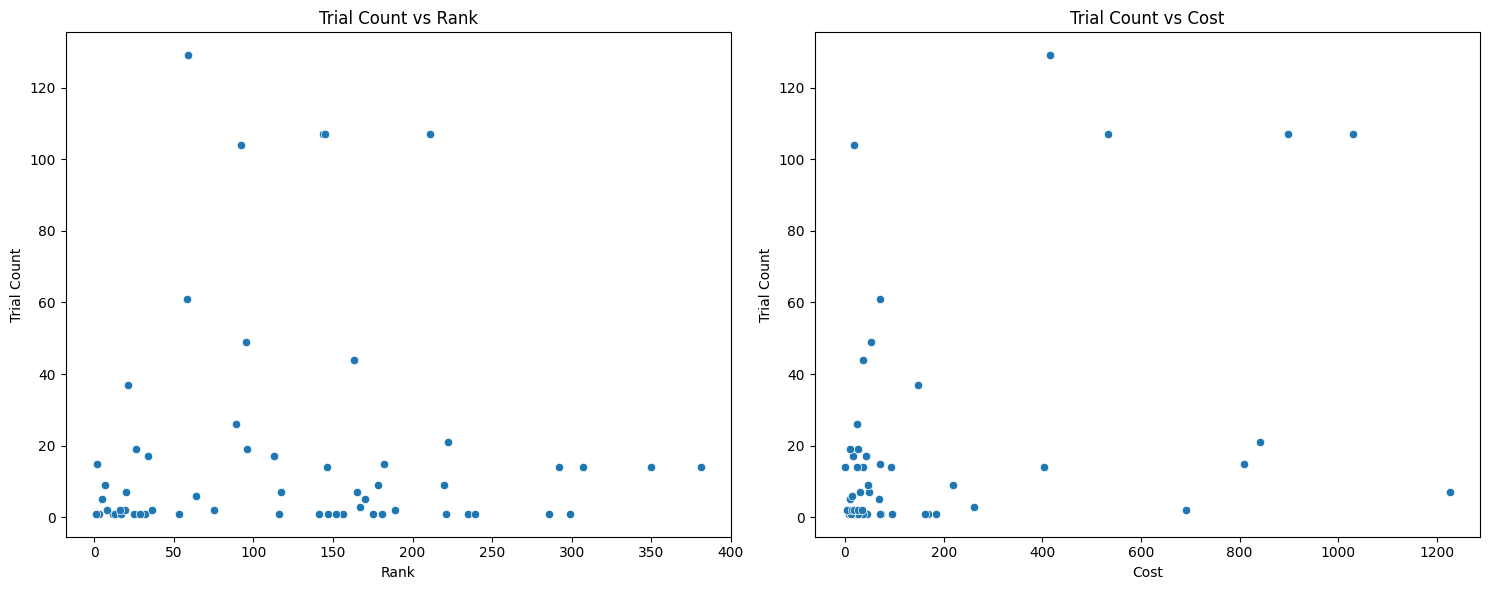

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: trial_count vs rank
sns.scatterplot(data=popular_prescription_most_trials_only, x='rank', y='trial_count', ax=ax1)
ax1.set_title('Trial Count vs Rank')
ax1.set_xlabel('Rank')
ax1.set_ylabel('Trial Count')


sns.scatterplot(data=popular_prescription_most_trials_only, x='cost', y='trial_count', ax=ax2)
ax2.set_title('Trial Count vs Cost')
ax2.set_xlabel('Cost')
ax2.set_ylabel('Trial Count')


plt.tight_layout()

# Show the plots
plt.show()

In [48]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [49]:

# Create a 3D scatter plot with hover information
fig = px.scatter_3d(
    popular_prescription_most_trials_only, 
    x='rank', 
    y='cost', 
    z='trial_count',
    color='trial_count',
    size='trial_count',
    size_max=15,
    opacity=0.8,
    color_continuous_scale=px.colors.sequential.Viridis,
    title='Interactive 3D Plot of Prescription Drugs',
    hover_name='name',  # This makes the name appear prominently on hover
    hover_data=['rank', 'cost', 'trial_count']  # Additional data for hover
)

# Update layout for better appearance
fig.update_layout(
    scene=dict(
        xaxis_title='Rank',
        yaxis_title='Cost',
        zaxis_title='Trial Count',
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    scene_camera=dict(
        eye=dict(x=1.5, y=1.5, z=1.5)
    )
)

# Customize hover template to control exactly what appears
fig.update_traces(
    hovertemplate='<b>%{hovertext}</b><br><br>' +
                  'Rank: %{x}<br>' +
                  'Cost: $%{y:.2f}<br>' +
                  'Trial Count: %{z}<br>' +
                  '<extra></extra>'  # This removes the trace name from the hover
)

# Show the plot
fig.show()

py.plot(fig, filename="trial_rank_cost", auto_open = True)
# If you want to save the interactive plot as an HTML file
# fig.write_html('interactive_3d_prescription_plot.html')

'https://chart-studio.plotly.com/~dgg32/1/'

In [75]:
query = """
SELECT 
  name,
  cost.unnest.year,
  cost.unnest.total as total_cost,
FROM 
  Prescription,
  UNNEST(prescription_cost_over_time) AS cost
WHERE "Top drug rank (2022)" <= 10
ORDER BY
  name,
  cost.unnest.year
"""


drug_price_over_year = con.execute(query).fetch_df()
drug_price_over_year

,name,year,total_cost
0,Albuterol,2013,50.23
1,Albuterol,2014,58.67
2,Albuterol,2015,55.42
3,Albuterol,2016,61.18
4,Albuterol,2017,61.62
...,...,...,...
95,Omeprazole,2018,58.16
96,Omeprazole,2019,33.05
97,Omeprazole,2020,16.18
98,Omeprazole,2021,17.02


In [76]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



fig = go.Figure()

# Get unique drugs
drugs = drug_price_over_year['name'].unique()

colors = px.colors.qualitative.Vivid
# Add a line for each drug
for i, drug in enumerate(drugs):
    drug_data = drug_price_over_year[drug_price_over_year['name'] == drug]
    color_idx = i % len(colors)
    fig.add_trace(
        go.Scatter(
            x=drug_data['year'],
            y=drug_data['total_cost'],
            mode='lines+markers',
            name=drug,
            line=dict(color=colors[color_idx], width=2),
            marker=dict(color=colors[color_idx], size=8),
            hovertemplate='<b>%{text}</b><br>Year: %{x}<br>Cost: $%{y:.2f}<extra></extra>',
            text=[drug] * len(drug_data)
        )
    )

fig.update_layout(
    showlegend=False
)
# Customize layout
fig.update_layout(
    title='Drug Costs Over Time',
    xaxis=dict(
        title='Year',
        tickmode='linear',
        dtick=1
    ),
    yaxis=dict(
        title='Total Cost (USD)',
        tickprefix='$',
        gridcolor='lightgray'
    ),
    hovermode='closest',
    height=600,
    width=900
)


# Show the plot
fig.show()

# Save the plot if needed
# fig.write_html('drug_costs_over_time.html')

#py.plot(fig, filename="pricing_history_top_30", auto_open = True)

In [52]:
drug_price_over_year.to_csv("drug_price_over_year.csv", index=False)

In [ ]:
con.close()